In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
curr_dir = os.getcwd()
print(curr_dir)

/teamspace/studios/this_studio/Preprocessing Eflow Images/code_dataset3


In [3]:
signal = pd.read_csv('/teamspace/studios/this_studio/Preprocessing Eflow Images/data/dataset3/sig_btagged2jets.txt', sep = '\t')
background = pd.read_csv('/teamspace/studios/this_studio/Preprocessing Eflow Images/data/dataset3/bg_btagged2jets.txt', sep = '\t')

In [4]:
columns = ['genphoton_Eta', 'genphoton_Phi', 'highb_Eta', 'highb_Phi','lowb_Eta', 'lowb_Phi']
signal_columns_extract = signal[columns]
background_columns_extract = background[columns]

In [43]:
class preprocessData():
    '''
    columns = ['genphoton_Eta', 'genphoton_Phi', 'highb_Eta', 'highb_Phi','lowb_Eta', 'lowb_Phi']
    '''
    def __init__(self):
        pass

    def shift_origin(self,x:pd.DataFrame) -> pd.DataFrame:
        #TODO: Take coordinates and subtract origin coordinates from it.
        # 1. Storing genphoton coordinates as origin
        origin = x.loc[:,['genphoton_Eta', 'genphoton_Phi']].values
    
        # 2. Subtracting origin from cooridnates of genphoton, highb, lowb
        genphoton_shift_coor = x.loc[:,['genphoton_Eta', 'genphoton_Phi']].values - origin
        highb_shift_coor = x.loc[:,['highb_Eta', 'highb_Phi']].values - origin
        lowb_shift_corr = x.loc[:,['lowb_Eta', 'lowb_Phi']].values - origin
    
        # Returning a new dataframe after concatenating updated coordinates
        return pd.DataFrame(np.concatenate([genphoton_shift_coor, highb_shift_coor, lowb_shift_corr], axis = 1), columns = ['genphoton_Eta', 'genphoton_Phi', 'highb_Eta', 'highb_Phi', 'lowb_Eta', 'lowb_Phi'])

    def rotate_coordinates(self,x:pd.DataFrame) -> pd.DataFrame:
        #TODO: Rotate the plane such that highb lies below genphoton(origin)
        y_axis = 0,-1 # -Y axis
        rotated_coordinates = pd.DataFrame(x[['genphoton_Eta', 'genphoton_Phi']])
        highb_rotated = []
        lowb_rotated = []
        # Loop for rotating each row by the corresponding theta
        for i in range(len(x)):
            row = x.iloc[i]
            # calculating theta using dot product between highb vector and -Y axis
            theta = np.arccos(np.dot(row.loc[['highb_Eta', 'highb_Phi']].values, y_axis)/np.linalg.norm(row.loc[['highb_Eta', 'highb_Phi']]))
            if row.loc['highb_Eta'] < 0:
                theta = -theta
            # Rotation matrix that rotates clockwise by theta
            rotation_matrix = np.array([
            [np.cos(-theta), -np.sin(-theta)],
            [np.sin(-theta),  np.cos(-theta)]
            ])
            # Operating rotation matrix on highb and lowb
            highb_rotated.append((rotation_matrix @ (row.loc[['highb_Eta', 'highb_Phi']].values).T).T)
            lowb_rotated.append((rotation_matrix @ (row.loc[['lowb_Eta', 'lowb_Phi']].values).T).T)
            
        highb_rotated = np.array(highb_rotated) # list to array
        lowb_rotated = np.array(lowb_rotated)
        # Storing the rotated data as columns of a new dataframe
        rotated_coordinates['highb_Eta'] = highb_rotated[:,0]
        rotated_coordinates['highb_Phi'] = highb_rotated[:,1]
        rotated_coordinates['lowb_Eta'] = lowb_rotated[:,0]
        rotated_coordinates['lowb_Phi'] = lowb_rotated[:,1]
    
        return rotated_coordinates

    def bound_phi(self, x:pd.DataFrame) -> pd.DataFrame:
        '''
        Normalize angles to the range (-π, π)

        This function takes angular values in any range and normalizes them to lie 
        within (-π, π) using the following steps:
        
        1. Transform negative angles to positive:
           - Add 2π to negative angles to get angles in range (0, 2π)
           
        2. Map angles larger than π to their equivalent in (-π, 0):
           - For angles > π: result = -(2π - angle)
        '''
        highb_phi = x['highb_Phi'].values
        lowb_phi = x['lowb_Phi'].values
        genphoton_phi = x['genphoton_Phi'].values

        updated_phi = np.zeros((len(x), 3))
        object_iterator = iter([highb_phi, lowb_phi, genphoton_phi])
        for col, obj in enumerate(object_iterator):
            for row, phi in enumerate(obj):
                if phi < 0:
                    updated_phi[row, col] = 2 * np.pi + phi
                else:
                    updated_phi[row, col] = phi

        for idx, phi in np.ndenumerate(updated_phi):
            if phi > np.pi:
                updated_phi[idx[0], idx[1]] = -1 * (2 * np.pi - updated_phi[idx[0], idx[1]])
        
        updated_x = x.copy()
        updated_x['highb_Phi'] = updated_phi[:,0]
        updated_x['lowb_Phi'] = updated_phi[:,1]
        updated_x['genphoton_Phi'] = updated_phi[:,2]

        return updated_x

    def plot_eflow_objects(self, x, ax, *, title: str = 'Plot'):
        """
        Plot eflow objects on a specified subplot
        
        Parameters:
            x: data to plot
            ax: matplotlib axes object to plot on
            title: plot title (optional)
        """
        # Add horizontal and vertical lines
        ax.axhline(0, color='black', linewidth=0.5)
        ax.axvline(0, color='black', linewidth=0.5)

        # Add horizontal lines at -π and π
        ax.axhline(-np.pi, color='red', linewidth=0.5, linestyle = '--')
        ax.axhline(np.pi, color='red', linewidth=0.5, linestyle = '--')
        
        # Add gridlines
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        # Set axis limits
        ax.set_xlim([-7,7])
        ax.set_ylim([-7,7])
        
        # Create scatter plots
        ax.scatter(x.loc['genphoton_Eta'], x.loc['genphoton_Phi'], 
                  label=f"genphoton:({x.loc['genphoton_Eta']:.2f},{x.loc['genphoton_Phi']:.2f})")
        ax.scatter(x.loc['highb_Eta'], x.loc['highb_Phi'], 
                  label=f"highb:({x.loc['highb_Eta']:.2f},{x.loc['highb_Phi']:.2f})", marker = 'x')
        ax.scatter(x.loc['lowb_Eta'], x.loc['lowb_Phi'], 
                  label=f"lowb:({x.loc['lowb_Eta']:.2f},{x.loc['lowb_Phi']:.2f})", marker = '.')
        
        # Set labels and title
        ax.set_title(title)
        ax.set_xlabel("Eta")
        ax.set_ylabel("Phi")
        ax.legend()
        plt.tight_layout()


    def plot_all(self, x, ax, *, title: str = 'Collective Plot'):
        """
        Plot all data points on a specified subplot
        
        Parameters:
            x: DataFrame containing the data to plot
            ax: matplotlib axes object to plot on
            title: plot title (optional)
        """
        # Add horizontal and vertical lines
        ax.axhline(0, color='black', linewidth=0.5)
        ax.axvline(0, color='black', linewidth=0.5)

        # Add horizontal lines at -π and π
        ax.axhline(-np.pi, color='red', linewidth=0.5, linestyle = '--')
        ax.axhline(np.pi, color='red', linewidth=0.5, linestyle = '--')
        
        # Add gridlines
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        # Set axis limits
        ax.set_xlim([-7, 7])
        ax.set_ylim([-7, 7])
        
        # Create scatter plots
        ax.scatter(x.loc[:,'highb_Eta'], x.loc[:,'highb_Phi'], label='highb', marker='x', c = 'orange')
        ax.scatter(x.loc[:,'lowb_Eta'], x.loc[:,'lowb_Phi'], label='lowb', marker='.', alpha = 0.8, c = 'green')
        ax.scatter(x.loc[:,'genphoton_Eta'], x.loc[:,'genphoton_Phi'], label='genphoton', c = 'blue')
        
        # Set labels and title
        ax.set_xlabel("Eta")
        ax.set_ylabel("Phi")
        ax.set_title(title)
        ax.legend()


    def Euclidean_distance(self, x:pd.DataFrame , obj1:str = 'highb', obj2:str = 'lowb') -> np.array:
        '''
        Calculate the Euclidean distance between 
        '''
        obj1_eta_phi = x[[obj1+'_Eta', obj1+'_Phi']].values
        obj2_eta_phi = x[[obj2+'_Eta', obj2+'_Phi']].values

        euclidean_distance = np.sqrt(np.sum((obj1_eta_phi - obj2_eta_phi)**2, axis = 1))
        return euclidean_distance


    def complete_transformation(self, x:pd.DataFrame,*, intermediate_bound_phi = True, final_bound_phi = True) -> pd.DataFrame:
        '''
        Function to do the origin shift, bounding phi, rotation and then bounding phi(optional) in on go.
        '''
        x_transformed = self.shift_origin(x)

        if intermediate_bound_phi:
            x_transformed = self.bound_phi(x_transformed)
        
        x_transformed = self.rotate_coordinates(x_transformed)

        if final_bound_phi:
            x_transformed = self.bound_phi(x_transformed)
            return x_transformed
        return x_transformed

    def invariant_mass(self, x:pd.DataFrame):
        '''
        Function to calculate invariant mass in each event
        '''
        total_energy = x.loc[:,['isophoton_E', 'jet1_E', 'jet2_E']].sum(axis = 1).values
        total_px = x.loc[:,['isophoton_Px', 'jet1_Px', 'jet2_Px']].sum(axis = 1).values
        total_py = x.loc[:,['isophoton_Py', 'jet1_Py', 'jet2_Py']].sum(axis = 1).values
        total_pz = x.loc[:,['isophoton_Pz', 'jet1_Pz', 'jet2_Pz']].sum(axis = 1).values

        inv_mass = np.sqrt(total_energy**2 - total_px**2 - total_py**2 - total_pz**2)
        return pd.DataFrame(inv_mass, columns = ['inv_mass'])

In [44]:
processor = preprocessData()

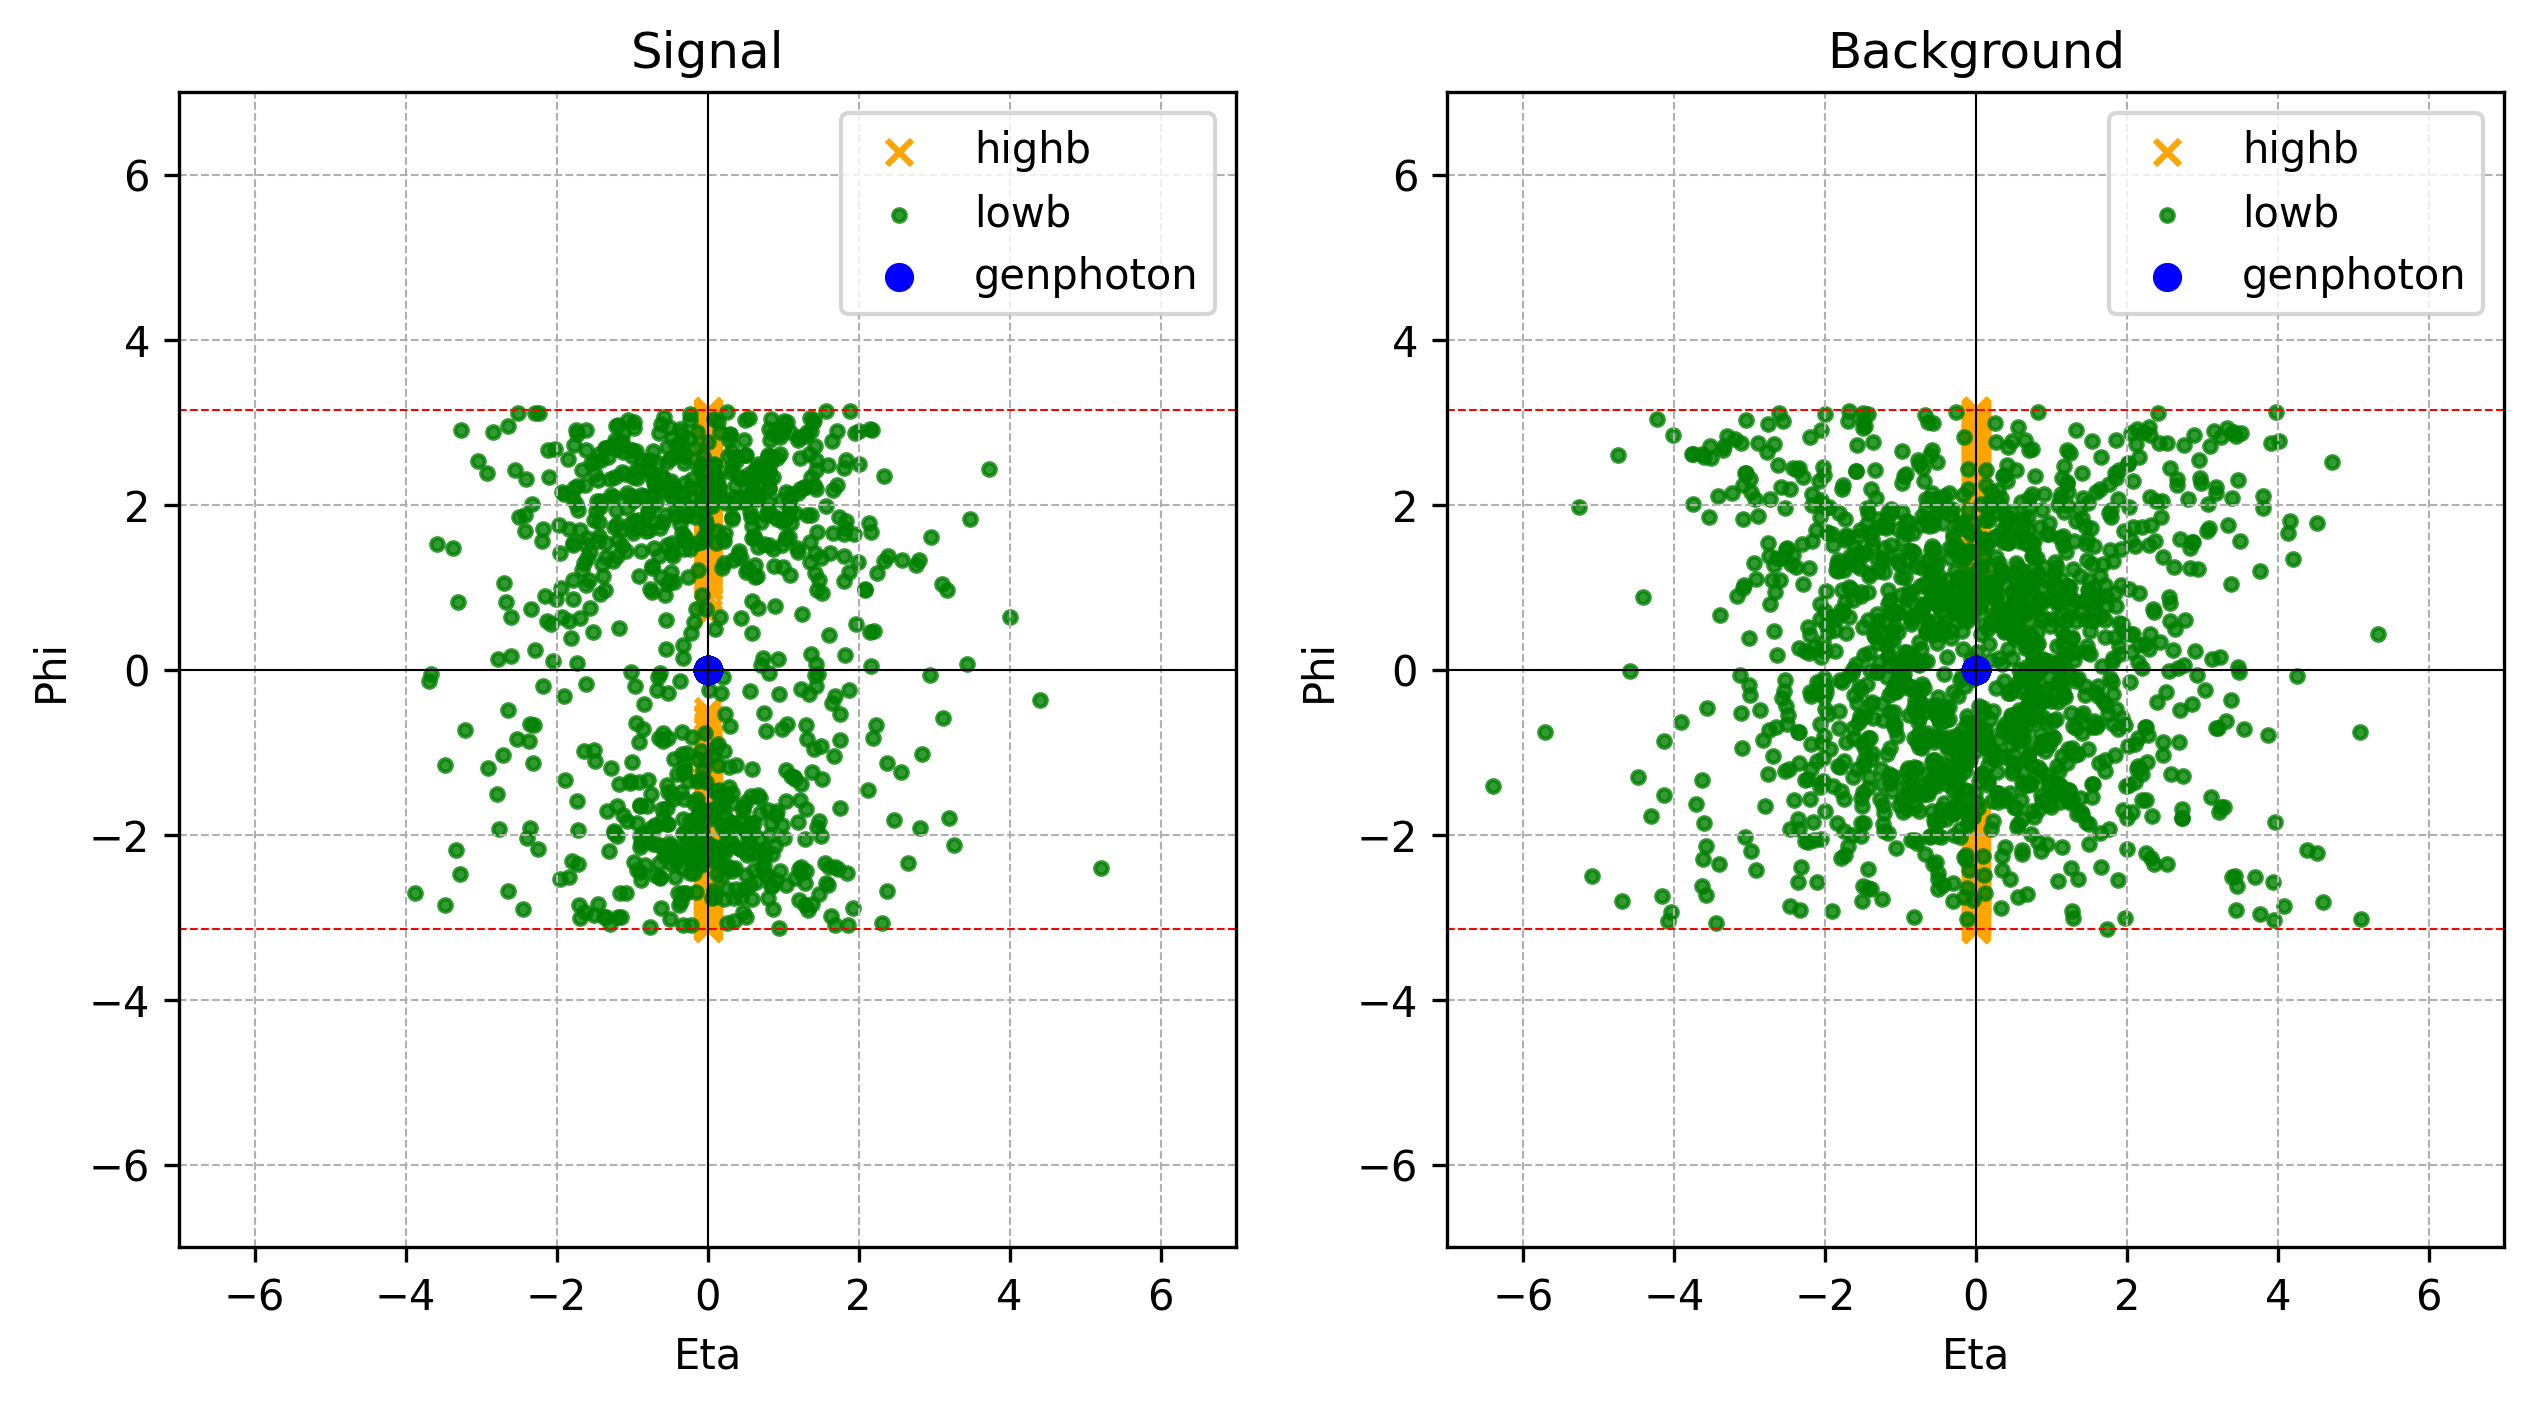

In [45]:
signal_final = processor.complete_transformation(signal_columns_extract, intermediate_bound_phi = False, final_bound_phi = True)
background_final = processor.complete_transformation(background_columns_extract, intermediate_bound_phi = False, final_bound_phi = True)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi = 300)
processor.plot_all(signal_final,
                   axs[0], title = 'Signal')
processor.plot_all(background_final,
                   axs[1], title = 'Background')
#plt.savefig('Final_Only_Bound.png')

## Calculating Euclidean Distances, R = $\sqrt{(\Delta \phi)^2 + (\Delta \eta)^2}$

In [46]:
signal_R_highb_lowb = processor.Euclidean_distance(signal_final)
background_R_highb_lowb = processor.Euclidean_distance(background_final)

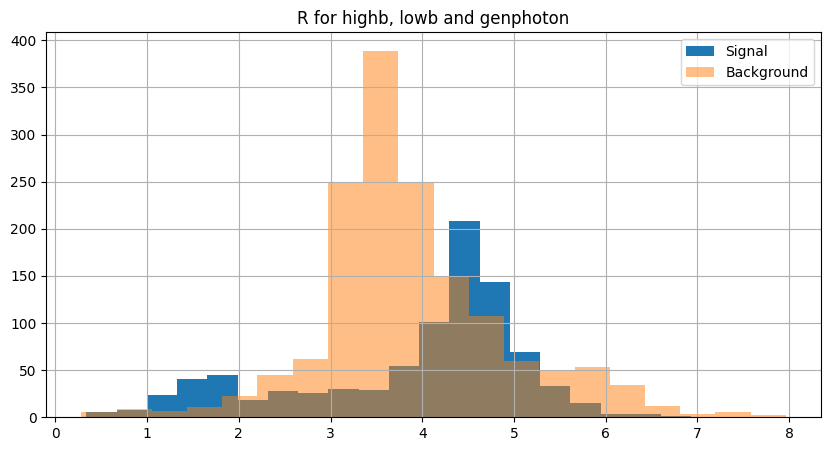

In [51]:
plt.figure(figsize = (10,5))
plt.hist(signal_R_highb_lowb, bins = 20, label = 'Signal')
plt.hist(background_R_highb_lowb, alpha = 0.5, bins = 20, label = 'Background')
plt.title('R for highb, lowb and genphoton')
plt.legend()
plt.grid()
plt.show()

In [48]:
signal_inv_mass = processor.invariant_mass(signal)
background_inv_mass = processor.invariant_mass(background)

In [ ]:
plt.figure(figsize = (10,5))
plt.hist(signal_inv_mass, bins = 20, label = 'Signal')
plt.hist(background_inv_mass, alpha = 0.5, bins = 20, label = 'Background')
plt.title('Invariant Mass Distribution for highb, lowb and genphoton')
plt.legend()
plt.grid()
plt.savefig('invmass_b.png', dpi = 200)
plt.show()